# Training the speech synthesis model - 2nd try

## Loading and cleaning spectrogram data

The first step that will be needed is to load spectrogram data. Since some files are missing, a few of the spectrograms will be completely empty and we would like to remove those.

In [1]:
import numpy as np
import mxnet as mx
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn, Block
from util import audio
import matplotlib.pyplot as plt
import pickle

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/tensorflow/python/framework/ops.py:939: DeprecationWarning: builtin type EagerTensor has no __module__ attribute
  EagerTensor = c_api.TFE_Py_InitEagerTensor(_EagerTensorBase)
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


In [2]:
#load everything
lstTextEncodings = pickle.load( open( "data/lsttxtencodings.p", "rb" ) )
lst_linspectrograms = pickle.load( open( "data/lstlinspectrograms.p", "rb" ) )
lst_melspectrograms = pickle.load( open( "data/lstmelspectrograms.p", "rb" ) )

Let us do some sanity check. We know that audio 400 is:

She never @ went back to school , # even later on when both of their sons were older , @ # and she thinks that Jeff's criticisms grew out of what he saw as her lack @ of ambition . # 

File: HAW-157-02

In [3]:
linspectrogram = lst_linspectrograms[400]
melspectrogram = lst_melspectrograms[400]
lstTextEncodings[400]

array([24, 13, 10,  0, 19, 10, 27, 10, 23,  0,  2,  0, 28, 10, 19, 25,  0,
        7,  6,  8, 16,  0, 25, 20,  0, 24,  8, 13, 20, 20, 17,  0,  3,  0,
        2,  0, 10, 27, 10, 19,  0, 17,  6, 25, 10, 23,  0, 20, 19,  0, 28,
       13, 10, 19,  0,  7, 20, 25, 13,  0, 20, 11,  0, 25, 13, 10, 14, 23,
        0, 24, 20, 19, 24,  0, 28, 10, 23, 10,  0, 20, 17,  9, 10, 23,  0,
        3,  0,  2,  0,  2,  0,  6, 19,  9,  0, 24, 13, 10,  0, 25, 13, 14,
       19, 16, 24,  0, 25, 13,  6, 25,  0, 15, 10, 11, 11,  2, 24,  0,  8,
       23, 14, 25, 14,  8, 14, 24, 18, 24,  0, 12, 23, 10, 28,  0, 20, 26,
       25,  0, 20, 11,  0, 28, 13,  6, 25,  0, 13, 10,  0, 24,  6, 28,  0,
        6, 24,  0, 13, 10, 23,  0, 17,  6,  8, 16,  0,  2,  0, 20, 11,  0,
        6, 18,  7, 14, 25, 14, 20, 19,  0,  4,  0,  2,  0])

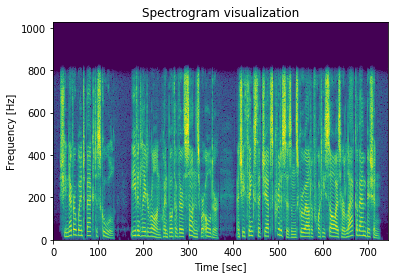

In [4]:
plt.pcolormesh(linspectrogram)
plt.title('Spectrogram visualization')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

We can also synthesize the audio to make sure it corresponds to what it should.

In [5]:
%%time
reconst_wav = audio.inv_spectrogram(linspectrogram)

Reconstructing with 60 iterations
CPU times: user 8.07 s, sys: 40 ms, total: 8.11 s
Wall time: 8.08 s


In [6]:
audio.save_wav(path='data/reconstrSANITYTrain.wav', wav=reconst_wav)

Let us now find and delete rows that correspond to blanks.

In [7]:
emptyIdx = []
for i in range(len(lst_linspectrograms)):
    spec = lst_linspectrograms[i]
    if np.count_nonzero(spec) == 0:
        #print('{}-th index is all zeros'.format(i))
        emptyIdx.append(i)
print(len(emptyIdx))

71


In [8]:
lstTextEncodings = [i for j, i in enumerate(lstTextEncodings) if j not in emptyIdx]
lst_linspectrograms = [i for j, i in enumerate(lst_linspectrograms) if j not in emptyIdx]
lst_melspectrograms = [i for j, i in enumerate(lst_melspectrograms) if j not in emptyIdx]

One last thing: if not all files have been processed, the text encodings will have more samples than the spectrograms.

In [9]:
lstTextEncodings = lstTextEncodings[:len(lst_linspectrograms)]
len(lstTextEncodings)

3143

In [10]:
nmax = 3000
lstTextEncodings = lstTextEncodings[:nmax]
lst_linspectrograms = lst_linspectrograms[:nmax]
lst_melspectrograms = lst_melspectrograms[:nmax]
len(lst_melspectrograms)

3000

In [11]:
import psutil
mem = psutil.virtual_memory()
mem.available/mem.total

0.8875582768728831

## Generate some dummy data

In [12]:
import numpy as np
import mxnet as mx
ctx = mx.gpu(0)

In [13]:
batch_test = [np.array([1,2,3,1,2,6])]
batch_test.append(np.array([3,2,1,1,5]))
batch_test.append(np.array([3,1,2,6]))
batch_test.append(np.array([1,2,2,6]))
batch_test.append(np.array([1,4,]))

curlen = len(batch_test)
for i in range(32-curlen):
    batch_test.append(np.array([0,4,4]))

batch_test[:6]

[array([1, 2, 3, 1, 2, 6]),
 array([3, 2, 1, 1, 5]),
 array([3, 1, 2, 6]),
 array([1, 2, 2, 6]),
 array([1, 4]),
 array([0, 4, 4])]

In [14]:
target_mel = []
target_lin = []
for i in range(32):
    seqlen = np.random.randint(600)
    mel_spec = np.random.randn(80,seqlen)
    lin_spec = np.random.randn(1025,seqlen)
    target_mel.append(mel_spec)
    target_lin.append(lin_spec)

[x.shape for x in target_mel[:6]]

[(80, 214), (80, 417), (80, 256), (80, 256), (80, 514), (80, 99)]

In [15]:
lst_melspectrograms[0].shape

(80, 573)

In [16]:
%run prepareBatches.py

In [17]:
sentence_batch = PadAndConcatChars(batch_test)
sentence_length = sentence_batch.shape[0]
sentence_batch.shape

(6, 32)

In [18]:
mel_batch = PadAndConcatSpec(target_mel)
mel_batch.shape

(580, 32, 80)

# Create the model

Let us create a function to do the concatenation

## Embedding

We perform individual embedding of each sequence. Let's define an embedding layer here. Later on it will be part of the full net. Let's say for this part that the number of symbols we consider is 32.

In [19]:
vocab_size=32
embedding_dim = 256
batch_size=32

In [20]:
#vocab size, embedding dimension
embedding = nn.Embedding(input_dim=32, output_dim=256)
embedding.initialize(ctx=ctx)

In [21]:
ndbatch = nd.array(sentence_batch.reshape(-1), dtype=int).as_in_context(ctx)
ndbatch.shape

(192,)

In [22]:
emb = embedding(ndbatch)
emb
embedding_dim

256

In [23]:
emb = emb.reshape((sentence_length,batch_size, embedding_dim))
emb.shape

(6, 32, 256)

## Pre-net

FC-256-ReLU !Dropout(0.5)

FC-128-ReLU !Dropout(0.5)


In [24]:
class PreNet(gluon.Block):
    def __init__(self, **kwargs):
        super(PreNet, self).__init__(**kwargs)
        
        with self.name_scope():
            self.fc1 = nn.Dense(256, activation='relu', flatten=False)
            self.dp1 = nn.Dropout(rate=0.5)
            self.fc2 = nn.Dense(128, activation='relu', flatten=False)
            self.dp2 = nn.Dropout(rate=0.5)
            
    def forward(self, x):
        x = self.fc1(x)
        x = self.dp1(x)
        x = self.fc2(x)
        x = self.dp2(x)
        return x
    

## CBHG - needs testing

In [25]:
class CBHG(Block):
    def __init__(self, hiddensize, K=16, batch_size=32):
        super(CBHG, self).__init__()
        self.K = K
        self.conv = []
        self.hiddensize = hiddensize
        with self.name_scope():
            
            self.conv = nn.Conv1D(channels=15, kernel_size=2*2+2, padding=2+1, activation='relu')
                
            self.maxpool0 = nn.MaxPool1D(pool_size=2, strides=1)
            self.bn0 = nn.BatchNorm()
            
            #projections
            self.convProj1 = nn.Conv1D(channels=1, kernel_size=3, padding=1, activation='relu')
            self.convProj2 = nn.Conv1D(channels=1, kernel_size=3, padding=1, activation=None)
            
            #Highway net: 4 layers of FC-128-ReLU
            self.fc1 = nn.Dense(128, activation='relu', flatten=False)
            self.fc2 = nn.Dense(128, activation='relu', flatten=False)
            self.fc3 = nn.Dense(128, activation='relu', flatten=False)
            self.fc4 = nn.Dense(128, activation='relu', flatten=False)

            
            self.bidirecgru = gluon.rnn.GRU(hidden_size=self.hiddensize, num_layers=1, bidirectional=True)
            

    def forward(self, x, hidden, batch_size=32):
        #input: x(batch_size, channels, data)
        xBkp = x
        
        y = self.conv(x)
        
        #print(y[0].shape)
        x = self.maxpool0(y)
        x = self.bn0(x)

        x = self.convProj1(x)
        x = self.convProj2(x)
        
        #residual connection
        x = xBkp + x
        
        #highway
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        
        #unstack 
        #print(x.shape)
        xx = x.reshape((-1, batch_size, x.shape[2]))
        
        #print(xx.shape)
        #print(type(hidden))
        #print(hidden[0].shape)
        x, newhidden = self.bidirecgru(xx, hidden)
        #print(newhidden[0].shape)
        
        return x, newhidden
    def initHidden(self, ctx, batch_size=32):
        return [nd.zeros((2, batch_size, self.hiddensize)).as_in_context(ctx)]

## TCN

In [26]:
prenet = PreNet()
prenet.initialize(ctx=ctx)

We need to prepare the features for the upcoming conv filters. Right now we have shape (batch_size, embedding_size)
We need to add a CHANNEL dimension before convolutions, i.e., (batch_size, 1, embedding_size)

In [27]:
class SimpleTacotron(gluon.Block):
    def __init__(self, **kwargs):
        super(SimpleTacotron, self).__init__(**kwargs)
        
        with self.name_scope():
            self.embedding = nn.Embedding(input_dim=32, output_dim=256)
            self.prenetEnc = PreNet()
            self.gruEnc = rnn.GRU(128, bidirectional=True)
            self.gruDec = rnn.GRUCell(512)
            
            self.fc1 = nn.Dense(256, activation='relu', flatten=False)
            self.fc2 = nn.Dense(80, activation='relu', flatten=False)
            
            self.mel2lin1 = nn.Dense(256, activation='relu', flatten=False)
            self.mel2lin2 = nn.Dense(512, activation='relu', flatten=False)
            self.mel2lin3 = nn.Dense(1025, activation='relu', flatten=False)
            
            self.gruDecLin1 = rnn.GRU(256)
            self.gruDecLin2 = rnn.GRU(1025)
            
            
    def forward(self, x, ctx, ndmel_batch=None, mel_seqlen = 1800):
        #we receive x as numpy array with shape (seq_size, batch_size)
            
        seq_size = sentence_batch.shape[0]
        batch_size = sentence_batch.shape[1]
        x = nd.array(x.reshape(-1), dtype=int).as_in_context(ctx)
        
        #encode
        x = self.embedding(x)
        x = self.prenetEnc(x)
        
        x = x.reshape((seq_size, batch_size, -1))
        
        hidden = nd.zeros((2, batch_size, 128)).as_in_context(ctx)
        x, hidden = self.gruEnc(x, hidden)
        
        #decode - we want to use last x and hidden from the encoder
        hidden = hidden[0].reshape((batch_size, -1))
        #print(x.shape)
        x = x[1,:,:]
        
        hiddenDec = [nd.concat(x,hidden,dim=1)] #shape: batch_size, 512
        
        if ndmel_batch is not None:
            mel_seqlen = ndmel_batch.shape[0]
        
        #print(ndmel_batch.shape)
        
        curframe = nd.zeros((batch_size, 80)).as_in_context(ctx)
        
        melDecoded = None
        
        for k in range(mel_seqlen):
            #print('curframe {} hiddendec {}'.format(curframe.shape, hiddenDec[0].shape))
            curmeldecoded, hiddenDec = self.gruDec(curframe, hiddenDec)
            
            curmeldecoded = self.fc1(curmeldecoded)
            curmeldecoded = self.fc2(curmeldecoded)
            
            #try a skip-connection here
            curmeldecoded = curmeldecoded + curframe
            
            reshapedMelDecoded = curmeldecoded.reshape((1, curmeldecoded.shape[0], curmeldecoded.shape[1]))
            if melDecoded is None:
                melDecoded = reshapedMelDecoded
            else:
                melDecoded = nd.concat(melDecoded, reshapedMelDecoded, dim=0)
            
            #print('melDecoded {}'.format(melDecoded.shape))
            
            curframe = curmeldecoded
            if ndmel_batch is not None: #if we have training data, input the truth
                curframe = ndmel_batch[k,:,:]
            else: #if not use this prediction as input
                curframe = curmeldecoded
            
            #print('curframe {} {}'.format(type(curframe), curframe.shape))
        
        linDecoded = melDecoded
        linDecoded = self.gruDecLin1(linDecoded)

        linDecoded = linDecoded.reshape((mel_seqlen*batch_size,-1))
        linDecoded = self.mel2lin1(linDecoded)
        linDecoded = self.mel2lin2(linDecoded)
        linDecoded = self.mel2lin3(linDecoded)
        linDecoded = linDecoded.reshape((mel_seqlen,batch_size,-1))
        
        linDecoded = self.gruDecLin2(linDecoded)
        
        return melDecoded, linDecoded

In [178]:
class CBHGTacotron(gluon.Block):
    def __init__(self, **kwargs):
        super(CBHGTacotron, self).__init__(**kwargs)
        
        with self.name_scope():
            self.embedding = nn.Embedding(input_dim=32, output_dim=256)
            self.prenetEnc = PreNet()
            self.gruEnc = CBHG(128)
            self.gruDec = rnn.GRUCell(512)
            
            self.fc1 = nn.Dense(256, activation='relu', flatten=False)
            self.fc2 = nn.Dense(80, activation='relu', flatten=False)
            
            self.mel2lin1 = nn.Dense(256, activation='relu', flatten=False)
            self.mel2lin2 = nn.Dense(512, activation='relu', flatten=False)
            self.mel2lin3 = nn.Dense(1025, activation='relu', flatten=False)
            
            self.gruDecLin1 = rnn.GRU(256)
            self.gruDecLin2 = rnn.GRU(1025)
            
            
    def forward(self, x, ctx, ndmel_batch=None, mel_seqlen = 1800):
        #we receive x as numpy array with shape (seq_size, batch_size)
            
        seq_size = sentence_batch.shape[0]
        batch_size = sentence_batch.shape[1]
        x = nd.array(x.reshape(-1), dtype=int).as_in_context(ctx)
        
        #encode
        x = self.embedding(x)
        x = self.prenetEnc(x)
        
        x = x.reshape((seq_size, batch_size, -1))
        
        hidden = nd.zeros((2, batch_size, 128)).as_in_context(ctx)
        x, hidden = self.gruEnc(x, hidden)
        
        #decode - we want to use last x and hidden from the encoder
        hidden = hidden[0].reshape((batch_size, -1))
        #print(x.shape)
        x = x[1,:,:]
        
        hiddenDec = [nd.concat(x,hidden,dim=1)] #shape: batch_size, 512
        
        if ndmel_batch is not None:
            mel_seqlen = ndmel_batch.shape[0]
        
        #print(ndmel_batch.shape)
        
        curframe = nd.zeros((batch_size, 80)).as_in_context(ctx)
        
        melDecoded = None
        
        for k in range(mel_seqlen):
            #print('curframe {} hiddendec {}'.format(curframe.shape, hiddenDec[0].shape))
            curmeldecoded, hiddenDec = self.gruDec(curframe, hiddenDec)
            
            curmeldecoded = self.fc1(curmeldecoded)
            curmeldecoded = self.fc2(curmeldecoded)
            
            #try a skip-connection here
            curmeldecoded = curmeldecoded + curframe
            
            reshapedMelDecoded = curmeldecoded.reshape((1, curmeldecoded.shape[0], curmeldecoded.shape[1]))
            if melDecoded is None:
                melDecoded = reshapedMelDecoded
            else:
                melDecoded = nd.concat(melDecoded, reshapedMelDecoded, dim=0)
            
            #print('melDecoded {}'.format(melDecoded.shape))
            
            curframe = curmeldecoded
            if ndmel_batch is not None: #if we have training data, input the truth
                curframe = ndmel_batch[k,:,:]
            else: #if not use this prediction as input
                curframe = curmeldecoded
            
            #print('curframe {} {}'.format(type(curframe), curframe.shape))
        
        linDecoded = melDecoded
        linDecoded = self.gruDecLin1(linDecoded)

        #print(' {}   {}'.format(linDecoded.shape, melDecoded.shape))

        linDecoded = linDecoded.reshape((mel_seqlen*batch_size,-1))
        linDecoded = self.mel2lin1(linDecoded)
        linDecoded = self.mel2lin2(linDecoded)
        linDecoded = self.mel2lin3(linDecoded)
        linDecoded = linDecoded.reshape((mel_seqlen,batch_size,-1))
        
        linDecoded = self.gruDecLin2(linDecoded)
        
        return melDecoded, linDecoded

In [132]:
stn = CBHGTacotron()
stn.initialize(ctx=ctx)
#sentence_batch

In [133]:
ndmel_batch = nd.array(mel_batch).as_in_context(ctx)
xx, yy = stn(sentence_batch, ctx, ndmel_batch)
xx.shape

(914, 32, 80)


(914, 32, 80)

In [134]:
ndmel_batch.shape

(914, 32, 80)

In [135]:
ndmel_batch[0:902,:,:].shape
xx[1:903,:,:].shape

(902, 32, 80)

In [137]:
nd.sum(ndmel_batch[0:902,:,:] - xx[1:903,:,:])


[-15328.46679688]
<NDArray 1 @gpu(0)>

## Training

In [179]:
%run preprocess.py
ppt = PreProcessText('lowercaseonly')
nchars = len(ppt.validChars)
print('nchars = {}'.format(nchars)) #32
tcn=CBHGTacotron()
#tcn.collect_params().initialize(mx.init.Xavier(), ctx=ctx)
tcn.collect_params().initialize(mx.init.Uniform(scale=0.1), ctx=ctx)

nchars = 32


In [180]:
desired_loss = gluon.loss.L1Loss()
scheduler = mx.lr_scheduler.FactorScheduler(10000, 0.96,1e-6)
trainer = gluon.Trainer(tcn.collect_params(), 'adam', {'learning_rate': .0005, 'lr_scheduler': scheduler, 'clip_gradient':0.3})

In [181]:
nsamples = len(lstTextEncodings)
nbatches = 500 // 32 *32
batch_size

32

In [182]:
cum_losses = []

In [183]:
epochs=120
nbatches = nsamples // batch_size * batch_size
epochNumber = 1
for e in range(epochs):
    cumulative_loss = 0
    num_examples=1
    perm = np.random.permutation(len(lstTextEncodings))

    for i in range(nbatches//batch_size):
        #print(i)
        batchidxs = [perm[i*batch_size + j] for j in range(batch_size)]
        #print(batchidxs)

        batchTest  =[lstTextEncodings[perm[i*batch_size + j]] for j in range(batch_size)]
        target_mel =[lst_melspectrograms[perm[i*batch_size + j]] for j in range(batch_size)]
        target_lin =[lst_linspectrograms[perm[i*batch_size + j]] for j in range(batch_size)]
        
        sentence_batch = PadAndConcatChars(batchTest)
        mel_batch = PadAndConcatSpec(target_mel)
        lin_batch = PadAndConcatSpec(target_lin)
        
        ndtarget_mel= nd.array(mel_batch).as_in_context(ctx)
        ndtarget_lin= nd.array(lin_batch).as_in_context(ctx)

        
        with autograd.record():
            decoded_melspec, decoded_linspec = tcn(sentence_batch, ctx, ndtarget_mel)
            #print('tgtlin {} tgtmel {} declin {} decmel {}'.format(ndtarget_lin.shape, ndtarget_mel.shape,decoded_linspec.shape, decoded_melspec.shape ))
            loss1 = desired_loss(decoded_melspec, ndtarget_mel)
            #print(nd.sum(loss1))
            loss2 = desired_loss(decoded_linspec, ndtarget_lin)
            #print(nd.sum(loss2))
            loss = loss1+loss2
            
        loss.backward()
        
        #print('stepping')
        #TODO: see what is making grad stale
        trainer.step(batch_size)
        cumulative_loss += nd.sum(loss).asscalar()/ndtarget_mel.shape[0]
        num_examples +=1
        
        print('Minibatch {} Loss = {} '.format(i, cumulative_loss/num_examples), end='\r')
        
        
    cum_losses.append(cumulative_loss/num_examples) 
    tcn.save_params('models/cbhgtacotron-epoch{}.model'.format(epochNumber))
    epochNumber += 1
    
    test_accuracy = 0 #evaluate_accuracy(test_data, net)
    train_accuracy = 0 #evaluate_accuracy(train_data, net)
    print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" %
          (e, cumulative_loss/num_examples, train_accuracy, test_accuracy))

 (841, 32, 256)   (841, 32, 80)
tgtlin (841, 32, 1025) tgtmel (841, 32, 80) declin (841, 32, 1025) decmel (841, 32, 80)
 (1099, 32, 256)   (1099, 32, 80)00885 
tgtlin (1099, 32, 1025) tgtmel (1099, 32, 80) declin (1099, 32, 1025) decmel (1099, 32, 80)
 (1049, 32, 256)   (1049, 32, 80)11285 
tgtlin (1049, 32, 1025) tgtmel (1049, 32, 80) declin (1049, 32, 1025) decmel (1049, 32, 80)
 (755, 32, 256)   (755, 32, 80)8531203 
tgtlin (755, 32, 1025) tgtmel (755, 32, 80) declin (755, 32, 1025) decmel (755, 32, 80)
 (993, 32, 256)   (993, 32, 80)8705963 
tgtlin (993, 32, 1025) tgtmel (993, 32, 80) declin (993, 32, 1025) decmel (993, 32, 80)
 (806, 32, 256)   (806, 32, 80)4443466 
tgtlin (806, 32, 1025) tgtmel (806, 32, 80) declin (806, 32, 1025) decmel (806, 32, 80)


KeyboardInterrupt: 

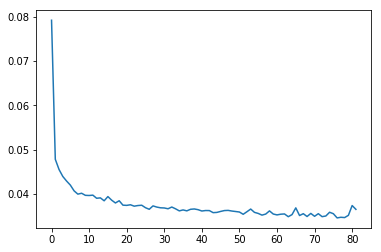

In [48]:
import matplotlib.pyplot as plt
plt.plot(cum_losses)
#cum_losses

In [196]:
decoded_melspec, decoded_linspec = tcn(sentence_batch, ctx) #, ndtarget_mel)
print(ndtarget_lin.shape)
print(ndtarget_mel.shape)

 (1800, 32, 256)   (1800, 32, 80)
(806, 32, 1025)
(806, 32, 80)


In [197]:
idx = 7
nplinspec_dec = decoded_linspec[:,idx,:].asnumpy().transpose()
nplinspec_tgt = ndtarget_lin[:,idx,:].asnumpy().transpose()
npmelspec_dec = decoded_melspec[:,idx,:].asnumpy().transpose()
npmelspec_tgt = ndtarget_mel[:,idx,:].asnumpy().transpose()

nplinspec_dec.shape

(1025, 1800)

In [198]:
nplinspec_tgt.shape

(1025, 806)

In [199]:
npmelspec_tgt.max()

0.77164507

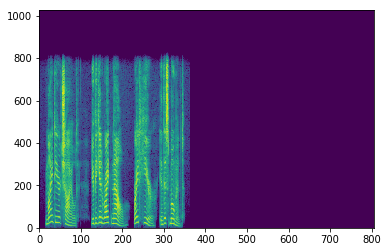

In [200]:
plt.pcolormesh(nplinspec_tgt)
plt.show()

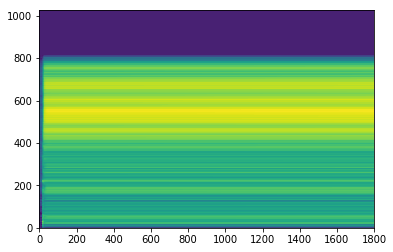

In [201]:
plt.pcolormesh(nplinspec_dec)
plt.show()

In [192]:
%%time
recTgt = audio.inv_spectrogram(nplinspec_tgt)
audio.save_wav(path='data/recTarget.wav', wav=recTgt)

Reconstructing with 60 iterations
CPU times: user 9.27 s, sys: 0 ns, total: 9.27 s
Wall time: 9.27 s


In [193]:
recTgt.max()

28322.307313752535

In [194]:
%%time
recDec = audio.inv_spectrogram(nplinspec_dec)
audio.save_wav(path='data/recReconst.wav', wav=recDec*50)

Reconstructing with 60 iterations
CPU times: user 9.28 s, sys: 0 ns, total: 9.28 s
Wall time: 9.28 s


In [195]:
recDec.max()

0.84672858293299824

In [105]:
2000000/500

4000.0

In [326]:

#tcn.save_params('simpletacotron.model')

In [185]:
tcn.load_params('models/cbhgtacotron-epoch82.model', ctx)